# Grouping and resampling

xarray was developed as an n-dimensional extension of [pandas](https://pandas.pydata.org), a very powerful data analysis library designed primarily for tabular data and time series analysis.

As a result xarray can utilise much of the time series manipulation power of pandas. The relevant xarray documentation is contained in the [GroupBy](http://xarray.pydata.org/en/stable/groupby.html) and [Time series data](http://xarray.pydata.org/en/stable/time-series.html) sections.

**NOTE**: This notebook has been updated to include proper weighting of spatial averages

In this case we need to do some extra imports to avoid pandas emitting warnings

In [1]:
import xarray, matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
%matplotlib inline

Load a CMIP5 air temperature data set into the variable `ds`, and make a variable, `tas`, which directly references the near surface air temperature `DataArray`

In [3]:
ds = xarray.open_dataset('http://dapds00.nci.org.au/thredds/dodsC/rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/mon/atmos/Amon/r1i1p1/latest/tas/tas_Amon_ACCESS1-3_historical_r1i1p1_185001-200512.nc')
tas = ds.tas

Calculate the 30 year climatology and anomalies as in the previous tutorial

In [4]:
tas_clim = tas.sel(time=slice('1960-01','1989-12')).mean(dim='time')
tas_anom = (tas - tas_clim)

**Update**: An operation which combines grid cells of different size is not scientifically valid unless each cell is weighted by the size of the grid cell. `xarray` has a convenient [weighted](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.weighted.html) method to accomplish this. 

First load the area data for this dataset

In [5]:
areacella = xarray.open_dataset('http://dapds00.nci.org.au/thredds/dodsC/rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/fx/atmos/fx/r0i0p0/latest/areacella/areacella_fx_ACCESS1-3_historical_r0i0p0.nc').areacella
areacella

<xarray.DataArray 'areacella' (lat: 145, lon: 192)>
array([[7.900114e+07, 7.900114e+07, 7.900114e+07, ..., 7.900114e+07,
        7.900114e+07, 7.900114e+07],
       [6.319696e+08, 6.319696e+08, 6.319696e+08, ..., 6.319696e+08,
        6.319696e+08, 6.319696e+08],
       [1.263641e+09, 1.263641e+09, 1.263641e+09, ..., 1.263641e+09,
        1.263641e+09, 1.263641e+09],
       ...,
       [1.263641e+09, 1.263641e+09, 1.263641e+09, ..., 1.263641e+09,
        1.263641e+09, 1.263641e+09],
       [6.319696e+08, 6.319696e+08, 6.319696e+08, ..., 6.319696e+08,
        6.319696e+08, 6.319696e+08],
       [7.900114e+07, 7.900114e+07, 7.900114e+07, ..., 7.900114e+07,
        7.900114e+07, 7.900114e+07]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:     cell_area
    long_name:         Atmosphere Grid-Cell Area
    units:             m2
    history:           2012-03-28T03:37:56Z altered by CMOR: replaced missing...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

As before, plotting the global anomaly from 1960 by time

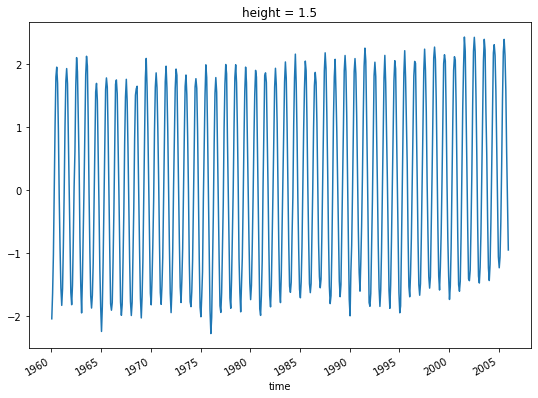

In [6]:
tas_anom.sel(time=slice('1960-01',None)).weighted(areacella).mean(dim=('lat','lon')).plot(size=6)

To highlight any global warming trend it would be better to show annual values. This can be done by resampling the data to an annual frequency. The `resample` method takes a dimension and resample period key/pair. In this case yearly frequency is specified with `Y` (see the pandas documentation for a [complete listing of frequency strings](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects)).

The `resample` method returns a resample object, which could be iterated over. In this case by specifying an operator (`mean`) this will be applied to each resampled period in turn, producing an annual mean in this case. Note that it is necessary to specify a dimension over which to apply the `mean` operator, otherwise  the operator will be applied across `lat` and `lon` reducing the dimensionality of the result. This is ultimately what is required, but keeping the spatial dimensions at this point is useful

In [7]:
tas_anom_yearly = tas_anom.sel(time=slice('1960-01',None)).resample(time='Y').mean(dim='time')
tas_anom_yearly.dims, tas_anom_yearly.shape

(('time', 'lat', 'lon'), (46, 145, 192))

The dimensions and shape show the time dimension has been reduced to 46 years

Now the area weighted global `mean` shows a clear warming trend over time

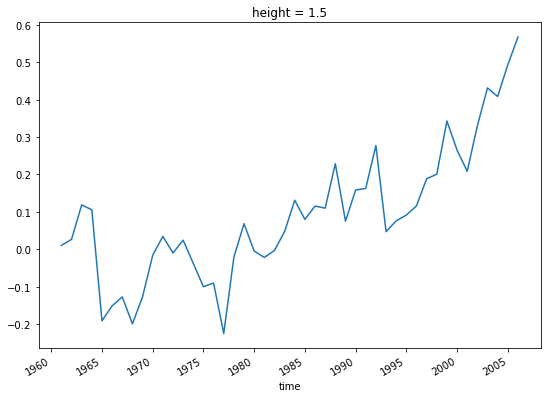

In [8]:
tas_anom_yearly.weighted(areacella).mean(dim=('lat','lon')).plot(size=6)

Because `tas_anom_yearly` still has spatial dimensions it is now possible to use `.sel` to calculate the same trend for the northern and southern hemisphere separately. Area weightings have been applied using the [weighted](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.weighted.html) method.

In the plot below to make the lines appear on the same plot it is necessary to specify the `matplotlib.axes` object directly so that it can be passed to each of the plots

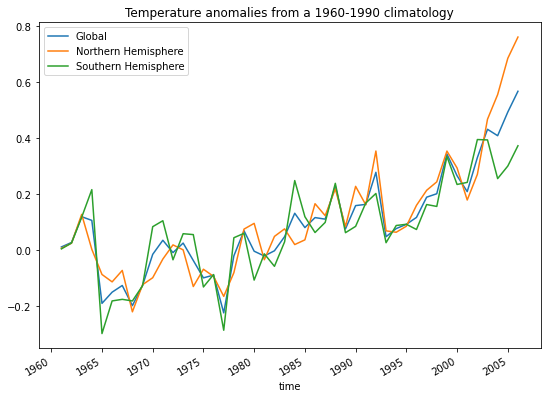

In [9]:
tas_anom_yearly.weighted(areacella).mean(dim=('lat','lon')).plot(size=6, label='Global')
tas_anom_yearly.sel(lat=slice(0,None)).weighted(areacella).mean(dim=('lat','lon')).plot(label='Northern Hemisphere')
tas_anom_yearly.sel(lat=slice(None,0)).weighted(areacella).mean(dim=('lat','lon')).plot(label='Southern Hemisphere')
plt.title('Temperature anomalies from a 1960-1990 climatology')
plt.legend()

Splitting into hemispheres shows both hemispheres are in sync for most of the plotted interval, but diverge in the last few years.

To go further and split the trend more finely in latitude it is easier to use the `xarray.groupby_bins` function. It is called with a coordinate and either a number of `bins` or an array of values specifying the start and end of each bin.

It returns a `groupby` object which can be iterated over, or chain a function which will applied to each group. 

To understand what the `groupby` is doing, here the `for` loop is iterating over the `groupby` object, which returns a tuple of interval and `DataArray` object. The interval and the dimensions and their shape show that each is just a `slice` of the data in latitude.

In [10]:
for i, d in tas_anom_yearly.groupby_bins('lat', bins=10):
    print(i, d.dims, d.shape)

(-90.18, -72.0] ('time', 'lat', 'lon') (46, 15, 192)
(-72.0, -54.0] ('time', 'lat', 'lon') (46, 14, 192)
(-54.0, -36.0] ('time', 'lat', 'lon') (46, 15, 192)
(-36.0, -18.0] ('time', 'lat', 'lon') (46, 14, 192)
(-18.0, 0.0] ('time', 'lat', 'lon') (46, 15, 192)
(0.0, 18.0] ('time', 'lat', 'lon') (46, 14, 192)
(18.0, 36.0] ('time', 'lat', 'lon') (46, 14, 192)
(36.0, 54.0] ('time', 'lat', 'lon') (46, 15, 192)
(54.0, 72.0] ('time', 'lat', 'lon') (46, 14, 192)
(72.0, 90.0] ('time', 'lat', 'lon') (46, 15, 192)


Below the same `groupby_bins` operation has the `mean` in `lat` and `lon` applied and then plotted. The `lat_bins` dimension is created by xarray, and by specifying that as the `hue` xarray automatially generates 10 individual lines, one for each bin, on the same plot (the semicolon at the end of the command suppresses undesirable messages from the matplotlib library).

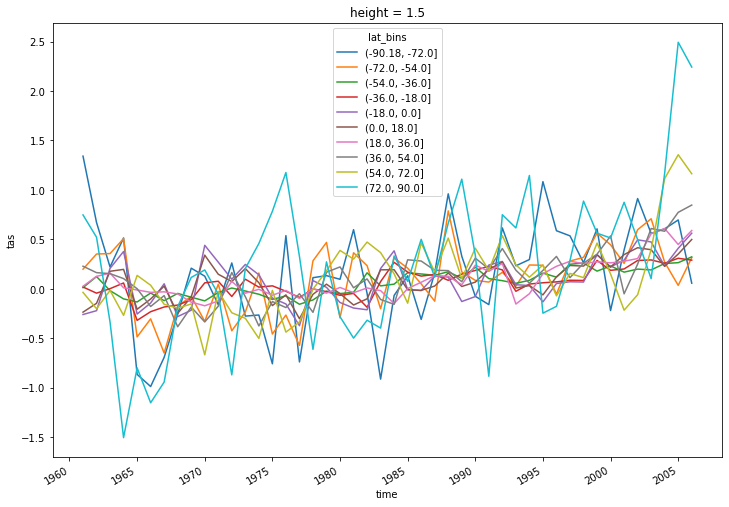

In [11]:
tas_anom_yearly.groupby_bins('lat', bins=10).mean(dim=('lat','lon')).plot(x='time',hue='lat_bins',size=8);

The plot above does not use an area-weighted mean, so is not scientifically valid, but does show how `groupby` and reduction methods like `mean` can be chained together to achieve a complex calculation and plot concisely.

To apply area-weighting is a bit more complex, as it is not *currently* possible to chain `groupby` and `weighted` methods directly. It can be achieved by specifying an function to calculate the weighted mean and `apply` that to the result of the `groupby`

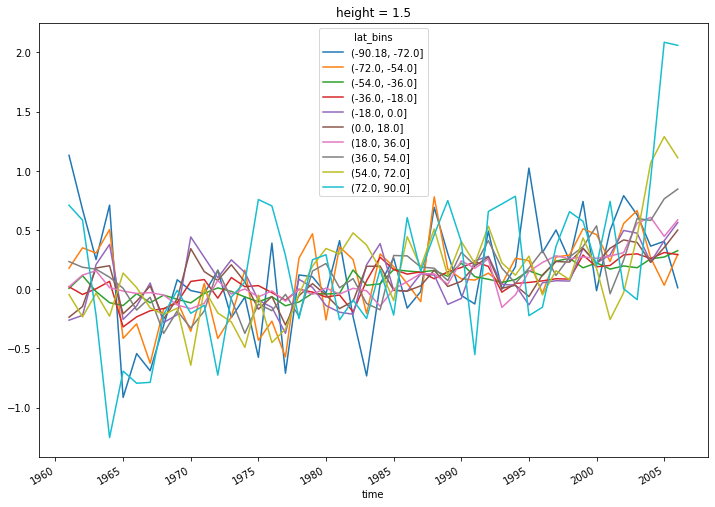

In [12]:
def weighted_mean(d):
    return d.weighted(areacella).mean(dim=('lat','lon'))

tas_anom_yearly.groupby_bins('lat', bins=10).apply(weighted_mean).plot(x='time',hue='lat_bins',size=8);

Finely grouping in latitude shows the rapid increase in anomalies at the end of the time series is dominated by large changes at the northern high latitudes.

xarray has some special virtual time coordinates. `time.season` is one of these. Below the seasonal mean of `tas` for each location is calculated and all plotted in a `FacetGrid` by specifying a `col` coordinate option to `plot`

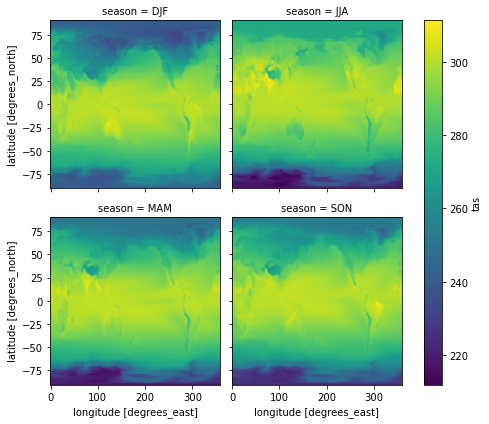

In [13]:
tas.groupby('time.season').mean(dim='time').plot(col='season', col_wrap=2)

Note that `tas` runs from January 1850 to December 2005

In [14]:
tas.time[0].values, tas.time[-1].values

(numpy.datetime64('1850-01-16T12:00:00.000000000'),
 numpy.datetime64('2005-12-16T12:00:00.000000000'))

This means a seasonal `DJF` grouping will only have two values for the first season of `DJF` and one value in the last season of `DJF`

In [15]:
tas.groupby('time.season').first()

<xarray.DataArray 'tas' (season: 4, lat: 145, lon: 192)>
array([[[240.83618, 240.83618, 240.83618, ..., 240.83191, 240.83191,
         240.83191],
        [242.67894, 242.65828, 242.63867, ..., 242.72214, 242.71056,
         242.69565],
        [243.58124, 243.52393, 243.46175, ..., 243.73363, 243.69022,
         243.6365 ],
        ...,
        [239.76013, 239.84523, 239.93364, ..., 239.52486, 239.60957,
         239.68538],
        [239.02599, 239.03561, 239.04205, ..., 239.04428, 239.03633,
         239.02672],
        [238.45506, 238.45506, 238.45506, ..., 238.45506, 238.45506,
         238.45506]],

       [[216.91147, 216.91147, 216.91147, ..., 216.90826, 216.90826,
         216.90826],
        [221.38907, 221.3119 , 221.24388, ..., 221.61159, 221.53627,
         221.46724],
        [221.35832, 221.19464, 221.01297, ..., 221.90044, 221.71968,
         221.54126],
...
        [241.89401, 241.97899, 242.06313, ..., 241.6638 , 241.74336,
         241.81006],
        [241.34007, 241.34734, 241.36183, ..., 241.28854, 241.29922,
         241.3213 ],
        [240.81412, 240.81412, 240.81412, ..., 240.81412, 240.81412,
         240.81412]],

       [[205.64325, 205.64325, 205.64325, ..., 205.64012, 205.64012,
         205.64012],
        [210.31404, 210.28319, 210.24283, ..., 210.42003, 210.38306,
         210.35304],
        [211.98454, 211.93123, 211.8833 , ..., 212.16982, 212.10542,
         212.04506],
        ...,
        [258.87402, 258.89883, 258.9098 , ..., 258.83072, 258.8426 ,
         258.8667 ],
        [258.88416, 258.88895, 258.90674, ..., 258.84503, 258.8582 ,
         258.8786 ],
        [259.00916, 259.00916, 259.00916, ..., 259.00916, 259.00916,
         259.00916]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 ...
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    units:             K
    cell_methods:      time: mean
    cell_measures:     area: areacella
    history:           2012-02-05T23:49:51Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...